In [1]:
import os
from glob import glob

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
# Load NIH data
df = pd.read_csv('/data/Data_Entry_2017.csv', index_col= 0)
df.shape

(112120, 11)

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['finding_labels', 'follow-up_#', 'patient_id', 'patient_age',
       'patient_gender', 'view_position', 'originalimage[width', 'height]',
       'originalimagepixelspacing[x', 'y]', 'unnamed:_11'],
      dtype='object')

In [5]:
df.isnull().mean(axis= 0)

finding_labels                 0.0
follow-up_#                    0.0
patient_id                     0.0
patient_age                    0.0
patient_gender                 0.0
view_position                  0.0
originalimage[width            0.0
height]                        0.0
originalimagepixelspacing[x    0.0
y]                             0.0
unnamed:_11                    1.0
dtype: float64

In [6]:
# Remove the columns with all NA values.
df = df.drop(['unnamed:_11'], axis= 1)

In [7]:
# Rename the dataframe for better readability.
df.columns = ['finding_labels', 'follow-up_#', 'patient_id', 'patient_age', 
              'patient_gender', 'view_position', 'img_width', 'img_height',
              'pixel_spacing_x', 'pixel_spacing_y']

# Show sample data.
df.sample(8, random_state= 0)

,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,img_width,img_height,pixel_spacing_x,pixel_spacing_y
Image Index,,,,,,,,,,
00002723_010.png,No Finding,10,2723,58,F,PA,2992,2991,0.143,0.143
00010377_002.png,No Finding,2,10377,66,M,AP,2500,2048,0.168,0.168
00007651_000.png,Cardiomegaly,0,7651,71,M,PA,2048,2500,0.168,0.168
00018514_000.png,No Finding,0,18514,56,F,PA,2992,2991,0.143,0.143
00010137_000.png,Nodule,0,10137,42,F,PA,2048,2500,0.168,0.168
00013111_003.png,Consolidation,3,13111,23,M,AP,3056,2544,0.139,0.139
00001483_009.png,Effusion|Mass,9,1483,53,F,PA,2992,2991,0.143,0.143
00019730_018.png,Atelectasis|Nodule,18,19730,32,F,AP,2372,2596,0.139,0.139


In [8]:
# Load 'sample_labels.csv' data for pixel level assessments
dflabel_sample = pd.read_csv('sample_labels.csv', index_col= 0)
dflabel_sample.shape

(5606, 10)

In [9]:
dflabel_sample.columns = dflabel_sample.columns.str.lower().str.replace(' ', '_')
dflabel_sample.columns = dflabel_sample.columns.str.replace('originalimage', 'img_')
dflabel_sample.columns

Index(['finding_labels', 'follow-up_#', 'patient_id', 'patient_age',
       'patient_gender', 'view_position', 'img_width', 'img_height',
       'img_pixelspacing_x', 'img_pixelspacing_y'],
      dtype='object')

In [10]:
dflabel_sample.sample(5, random_state= 0)

,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,img_width,img_height,img_pixelspacing_x,img_pixelspacing_y
Image Index,,,,,,,,,,
00003838_000.png,No Finding,0,3838,052Y,F,PA,2048,2500,0.168,0.168
00008127_001.png,No Finding,1,8127,032Y,F,PA,2048,2500,0.168,0.168
00027001_001.png,No Finding,1,27001,057Y,F,AP,3056,2544,0.139,0.139
00017950_001.png,Infiltration,1,17950,027Y,F,PA,2702,2991,0.143,0.143
00018507_012.png,No Finding,12,18507,070Y,M,PA,2992,2991,0.143,0.143


## EDA

In [11]:
df.loc[df['patient_age'] >= 100]

,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,img_width,img_height,pixel_spacing_x,pixel_spacing_y
Image Index,,,,,,,,,,
00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139
00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139
00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143
00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143
00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143
00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143
00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143
00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143
00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139


In [12]:
df = df.loc[df['patient_age'] < 100]

In [13]:
df['patient_age'].describe().round(1)

count    112104.0
mean         46.9
std          16.6
min           1.0
25%          35.0
50%          49.0
75%          59.0
max          95.0
Name: patient_age, dtype: float64

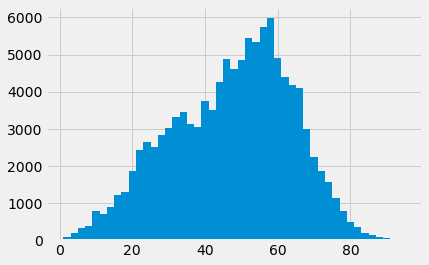

In [14]:
plt.hist(df['patient_age'], bins= 47);

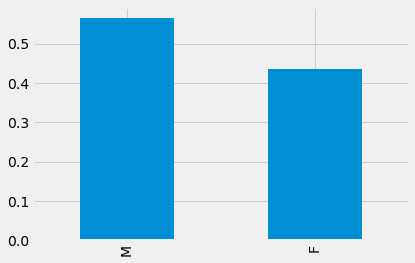

In [15]:
df['patient_gender'].value_counts(dropna= False, normalize= True).plot(kind= 'bar');

### Findings

For some of the images there are multiple findings. I'll separate the findings into multiple columns with one-hot-encoding technique. Furthermore, I'll convert the findings to lowercase.

In [16]:
df['finding_labels'].head(10)

Image Index
00000001_000.png              Cardiomegaly
00000001_001.png    Cardiomegaly|Emphysema
00000001_002.png     Cardiomegaly|Effusion
00000002_000.png                No Finding
00000003_000.png                    Hernia
00000003_001.png                    Hernia
00000003_002.png                    Hernia
00000003_003.png       Hernia|Infiltration
00000003_004.png                    Hernia
00000003_005.png                    Hernia
Name: finding_labels, dtype: object

In [17]:
dffindings = df['finding_labels'].str.lower().str.replace(' ', '_').str.get_dummies()
print(f'Overall, there are {dffindings.shape[1]} different findings for all the images.')

Overall, there are 15 different findings for all the images.


In [18]:
# These are the various findings
dffindings.columns.values

array(['atelectasis', 'cardiomegaly', 'consolidation', 'edema',
       'effusion', 'emphysema', 'fibrosis', 'hernia', 'infiltration',
       'mass', 'no_finding', 'nodule', 'pleural_thickening', 'pneumonia',
       'pneumothorax'], dtype=object)

In [19]:
dffindings.head(3)

,atelectasis,cardiomegaly,consolidation,edema,effusion,emphysema,fibrosis,hernia,infiltration,mass,no_finding,nodule,pleural_thickening,pneumonia,pneumothorax
Image Index,,,,,,,,,,,,,,,
00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0


''

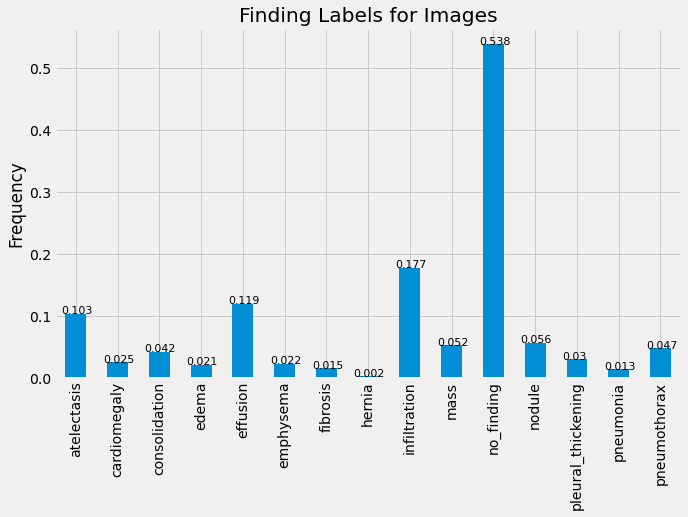

In [20]:
plt.figure(figsize= (10, 6))
s = dffindings.mean().round(3)
s.plot(kind= 'bar')
for ix, m in enumerate(s):
    plt.text(x = ix - .35 , y = m, s = m, size = 11)
plt.title('Finding Labels for Images')
plt.ylabel('Frequency')
;